In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import scipy.stats as st

In [2]:
class PortfolioData():
    
    def __init__(self, tickers):
        self.bench_ticker = 'BOVA11'
        self.tickers = tickers
        self.returns = self.historicalReturn(self.tickers+[self.bench_ticker])
        self.u = self.returns[tickers].mean().tolist()
        self.u = [252*u for u in self.u]
        self.var = self.returns[tickers].var().tolist()
        self.var = [252*v for v in self.var]
        self.std = self.returns[tickers].std().tolist()
        self.std = [np.sqrt(252)*s for s in self.std]
        self.rho = np.array(self.returns[tickers].corr())[0][1]
        
    def historicalReturn(self, tickers):
        prices = yf.download([f'{stock}.SA' for stock in tickers], start='2019-01-01', group_by='column')[['Close']]
        returns = prices.pct_change().fillna(0)
        returns.columns=tickers
        
        return returns 


In [66]:
class PortfolioOptmizer():
    
    def weights_by_asset(self, u_p):
        w_1 = (u_p-self.u[1])/(self.u[0]-self.u[1])
        w_2 = (self.u[0]-u_p)/(self.u[0]-self.u[1])

        return w_1, w_2
    
    def variance_for_two_assets(self, w_1, w_2):
        return (w_1**2)*self.var[0] + (w_2**2)*self.var[1] + 2*w_1*w_2*np.sqrt(self.var[0]*self.var[1])*self.rho

    def efficient_frontier(self):
        std = []
        var_1 = self.var[0]
        var_2 = self.var[1]
        upaxis = np.linspace(0, 2*np.sum(self.var), 200)
        frontier = {}
        for u_p in upaxis:
            w_1, w_2 = self.weights_by_asset(u_p)
            frontier[u_p] = np.sqrt(self.variance_for_two_assets(w_1, w_2))

        return frontier
    
    def _u_for_minimal_variance_risk_portfolio(self):
        numerator = self.u[0]*self.var[1]+self.u[1]*self.var[0] - (self.u[0]+self.u[1])*np.sqrt(self.var[0]*self.var[1])*self.rho
        denominator = self.var[0] + self.var[1] - 2*np.sqrt(self.var[0]*self.var[1])*self.rho

        self.u_for_minimal_variance_risk_portfolio = numerator/denominator
        
    def _minimal_variance_risk_portfolio(self):
        var_p = self.variance_for_two_assets(self.w_1_minimal_variance, self.w_2_minimal_variance)
        self.minimal_variance_risk_portfolio = var_p
        
    def _weights_for_minimal_variance(self):
        self.w_1_minimal_variance, self.w_2_minimal_variance = self.weights_by_asset(self.u_for_minimal_variance_risk_portfolio)
    
    def _u_for_maximum_sharpe(self):
        difference_between_u = (self.u[0]-self.u[1])**2
        beta_parabola = -2*(self.u[0]*self.var[1]+self.u[1]*self.var[0] - (self.u[0]+self.u[1])*np.sqrt(self.var[0]*self.var[1])*self.rho)/difference_between_u
        alpha_parabola = (self.var[0] + self.var[1] - 2*np.sqrt(self.var[0]*self.var[1])*self.rho)/difference_between_u
        gamma_parabola = ((self.u[0]**2)*self.var[1]+(self.u[1]**2)*self.var[0] - 2*(self.u[0]*self.u[1])*np.sqrt(self.var[0]*self.var[1])*self.rho)/difference_between_u
        self.u_for_maximum_sharpe = -(beta_parabola*self.r_f + 2*gamma_parabola)/(2*alpha_parabola*self.r_f+beta_parabola)
    
    def _weights_for_maximum_sharpe(self):
        u_p = self.u_for_maximum_sharpe
        self.w_1_max_sharpe, self.w_2_max_sharpe = self.weights_by_asset(u_p)
        
    def _variance_for_maximum_sharpe(self):
        self.variance_for_maximum_sharpe = self.variance_for_two_assets(self.w_1_max_sharpe, self.w_2_max_sharpe)
    
    def sharpe_ratio(self, u, var, r_f):
        return (u - r_f) / np.sqrt(var)

    def _max_sharpe_ratio(self):
        u_p = self.u_for_maximum_sharpe
        var_p = self.variance_for_maximum_sharpe
    
        self.max_sharpe_ratio = self.sharpe_ratio(u_p, var_p, self.r_f)
    
    def _risk_asset_composition_pgi(self):
        s_p = self.max_sharpe_ratio
        var_p = self.variance_for_maximum_sharpe

        self.risk_asset_composition_pgi = (1 / self.gamma) * (s_p / np.sqrt(var_p))
        
    def _weights_for_pgi(self):
        self.w1_pgi = self.w_1_max_sharpe * self.risk_asset_composition_pgi
        self.w2_pgi = self.w_2_max_sharpe * self.risk_asset_composition_pgi
        self.w_rf_pgi = 1-self.risk_asset_composition_pgi
        
        
    def _u_for_pgi(self):
        self.u_pgi = self.risk_asset_composition_pgi*self.u_for_maximum_sharpe+(1-self.risk_asset_composition_pgi)*self.r_f
        
    def _var_for_pgi(self):
        self.var_pgi = (self.risk_asset_composition_pgi**2)*self.variance_for_maximum_sharpe
        self.std_pgi = np.sqrt(self.var_pgi)
        
    def _max_utility(self):
        self.max_utility = self.quadratic_utility_function(self.u_pgi, self.var_pgi, self.gamma)
        
    def _generate_lac(self):
        u_lac = []
        std_axis = []
        u_p = self.u_for_maximum_sharpe
        var_p = self.variance_for_maximum_sharpe
        for std_ in np.linspace(0, 2*np.sum(self.var), 300):
            std_axis.append(std_)
            a = (u_p - self.r_f)/np.sqrt(var_p)
            u_lac.append(a*std_+self.r_f)
        return std_axis, u_lac
        
    def _generate_utility_curve(self):
        u_preference = []
        std_axis = []
        for std_ in np.linspace(0, 2*np.sum(self.var), 300):
            std_axis.append(std_)
            u_preference.append(self.inverse_quadratic_utility_function(self.max_utility, std_**2, self.gamma))
        
        return std_axis, u_preference
    
    def load_params(self):
        self._u_for_minimal_variance_risk_portfolio()
        self._weights_for_minimal_variance()
        self._minimal_variance_risk_portfolio()
        self._u_for_maximum_sharpe()
        self._weights_for_maximum_sharpe()
        self._variance_for_maximum_sharpe()
        self._max_sharpe_ratio()
        self._risk_asset_composition_pgi()
        self._u_for_pgi()
        self._var_for_pgi()
        self._weights_for_pgi()
        self._max_utility()
    
    def quadratic_utility_function(self, u, var, gamma):
        return u - (1/2)*gamma*var

    def inverse_quadratic_utility_function(self, utility, var, gamma):
        return utility + (1/2)*gamma*var
    
    def plot_efficient_frontier(self):
        plt.figure(figsize=(10,10))
        frontier = self.efficient_frontier()
        plt.plot([v for v in frontier.values()], [k for k in frontier.keys()])
        plt.title('Fronteira eficiente')
        plt.xlabel('Desvio padrão')
        plt.ylabel('Retorno esperado')
        plt.grid()
        plt.show()
    
    def plot_lac(self):
        lac = self._generate_lac()
        plt.figure(figsize=(10,10))
        plt.plot(lac[0], lac[1])
        plt.title('Linha de alocação de capital - Fronteira eficiente para o portifolio geral do investidor')
        plt.xlabel('Desvio padrão')
        plt.ylabel('Retorno esperado')
        plt.grid()
        plt.show()
    
    def plot_utility_function_for_max_utility(self):
        std_axis, u_preference = self._generate_utility_curve()
        plt.figure(figsize=(10,10))
        plt.plot(std_axis, u_preference)
        plt.title('Função de utilidade')
        plt.xlabel('Desvio padrão')
        plt.ylabel('Retorno esperado')
        plt.grid()
        plt.show()
        
    def plot_curves(self):
        frontier = self.efficient_frontier()
        std_axis, u_preference = self._generate_utility_curve()
        lac = self._generate_lac()
        plt.figure(figsize=(14,14))
        plt.plot(std_axis, u_preference, label='Função de utilidade')
        plt.plot(lac[0], lac[1], label='Fronteira eficiente para o portifolio geral do investidor')
        plt.plot([v for v in frontier.values()], [k for k in frontier.keys()], label='Fronteira eficiente')
        plt.scatter(np.sqrt(self.var_pgi), self.u_pgi, marker='^', s=300, label='Portfolio geral do investidor')
        plt.scatter(np.sqrt(self.variance_for_maximum_sharpe), self.u_for_maximum_sharpe, marker='^', s=300, label='Portfolio de Sharpe máximo')
        plt.text(0.5*np.sqrt(self.var_pgi), 1.1*self.u_pgi, f'Risk-free asset weight: {self.w_rf_pgi:.2f} \nAsset 1 weight: {self.w1_pgi:.2f} \nAsset 2 weight: {self.w2_pgi:.2f}')
        plt.text(1.05*np.sqrt(self.variance_for_maximum_sharpe), 0.9*self.u_for_maximum_sharpe, f'Asset 1 weight: {self.w_1_max_sharpe:.2f} \nAsset 2 weight: {self.w_2_max_sharpe:.2f}')
        plt.legend()
        plt.title('Análise de portifólio')
        plt.xlabel('Desvio padrão')
        plt.ylabel('Retorno esperado')
        plt.xlim([0, 5*self.variance_for_maximum_sharpe])
        plt.ylim([0, 2*self.u_for_maximum_sharpe])
        plt.grid()
        plt.show()
    
    def set_u(self, u):
        self.u = u
        self.load_params()
        print(f'New mu parameters set to {self.u}')
    
    def set_var(self, var):
        self.var = var
        self.std = [np.sqrt(v) for v in self.var]
        self.load_params()
        print(f'New variance parameters set to {self.var}')
    
    def set_std(self, std):
        self.std = std
        self.var = [252*(s**2) for s in self.std]
        self.load_params()
        print(f'New standart deviation parameters set to {self.std}')
        
    def set_r_f(self, r_f):
        self.r_f = r_f
        self.load_params()
        print(f'New risk-free rate parameter set to {self.r_f}')
        
    def set_rho(self, rho):
        self.rho = rho
        self.load_params()
        print(f'New correlation parameter set to {self.rho}')
        
    def set_gamma(self, gamma):
        self.gamma = gamma
        self.load_params()
        print(f'New risk-aversion parameter set to {self.gamma}')
        

        

In [99]:
class RiskUtils():
    @staticmethod
    def valueAtRisk(initial_value, std, alpha=0.95, N=1, u=0):
        return abs(initial_value * ((st.norm.ppf(1-alpha) * std) + u) * np.sqrt(N))
    
    @staticmethod
    def valueAtRiskForNAssets(initial_value, asset_percentage, std, rho, alpha = 0.95, N = 1):
        if len(asset_percentage) != len(std):
            raise ValueError('Length of variables is wrong')

        number_of_assets = len(asset_percentage)

        sum_list = []

        for i in range(number_of_assets):
            for j in range(number_of_assets):
                sum_list.append(rho[i][j]*asset_percentage[i]*asset_percentage[j]*std[i]*std[j])

        variance_p = np.sum(sum_list)
        std_p = np.sqrt(variance_p)

        return RiskUtils.valueAtRisk(initial_value, std_p, alpha, N)
    
    @staticmethod
    def valueAtRiskForTwoAssets(initial_value, asset_percentage, std, rho, alpha = 0.95, N = 1):
        if len(asset_percentage) != len(std):
            raise ValueError('Length of variables is wrong')

        variance_p = rho*asset_percentage[0]*asset_percentage[1]*std[0]*std[1]
        std_p = np.sqrt(variance_p)

        return RiskUtils.valueAtRisk(initial_value, std_p, alpha, N)
    
    @staticmethod
    def historicalValueAtRisk(initial_value, return_vector, alpha = 0.95, N = 1):
        return abs(initial_value * np.percentile(return_vector, (1 - alpha)*100) * np.sqrt(N))

    @staticmethod
    def mcReturns(std, n_simulations):
        simulated_returns = []
        for _ in range(n_simulations):
            uniform_random = np.random.uniform()
            normal_sample = st.norm.ppf(uniform_random)
            simulated_returns.append(normal_sample*std)

        return simulated_returns
    
    @staticmethod
    def mcVaR(initial_value, std, alpha = 0.95, N = 1, n_simulations = 10000):
        simulated_returns = RiskUtils.mcReturns(std, n_simulations)
        return RiskUtils.historicalValueAtRisk(initial_value, simulated_returns, alpha, N)

In [100]:
class RiskManager(RiskUtils):
    
    def get_portfolio_var(self):
        print(f'Portfolio 1-day 95% V@R is {self.portfolio_var:.2f}')
    
    def get_assets_mc_var(self):
        self._gen_assets_mc_var()
        
        return self.mc_assets_var
        
    def _gen_assets_var(self):
        self.assets_var = {}
        for i in range(len(self.tickers)):
            self.assets_var[self.tickers[i]]= self.valueAtRisk(self.assets_values[i], self.std[i], N=1)

        return self.assets_var

    def _gen_assets_mc_var(self):
        self.mc_assets_var = {}
        for i in range(len(self.tickers)):
            self.mc_assets_var[self.tickers[i]] = self.mcVaR(self.assets_values[i], self.returns.std().values[i])
    
    def print_assets_var(self):
        for i in range(len(self.tickers)):
            print(f'1-day 95% V@R for {self.tickers[i]} is {self.assets_var[self.tickers[i]]:.2f}')
    
    def print_assets_mc_var(self):
        self._gen_assets_mc_var()
        for i in range(len(self.tickers)):
            print(f'1-day 95% Monte Carlo V@R for {self.tickers[i]} is {self.mc_assets_var[self.tickers[i]]:.2f}')
        

        

In [101]:
class TwoAssetsPortfolio(PortfolioData, PortfolioOptmizer, RiskManager):
    
    def __init__(self, tickers, weights, r_f, gamma, portfolio_value=100*1000):
        super().__init__(tickers)
        self.tickers = tickers
        self.var_bench = self.returns[self.bench_ticker].var()
        self.u_bench = self.returns[self.bench_ticker].mean()
        self.weights = weights
        self.portfolio_value = portfolio_value
        self.assets_values = [weight*portfolio_value for weight in weights]
        self.r_f = r_f
        self.gamma = gamma
        self.calculate_beta_portfolio()
        self.calculate_expected_return()
        self.load_params()
        self._gen_assets_var()
        self.portfolio_var = self.valueAtRiskForNAssets(self.portfolio_value, self.weights, self.returns[self.tickers].std().values, np.array(self.returns[self.tickers].corr()), N=1)
        
    def calculate_beta_portfolio(self):
        self.beta_assets = (self.returns.cov().iloc[-1]/self.returns['BOVA11'].var())[:-1]
        self.beta_portfolio = np.sum(self.beta_assets)
        
    def calculate_expected_return(self):
        self.expected_return = self.r_f + self.beta_portfolio*(self.u_bench-self.r_f)

[*********************100%***********************]  3 of 3 completed


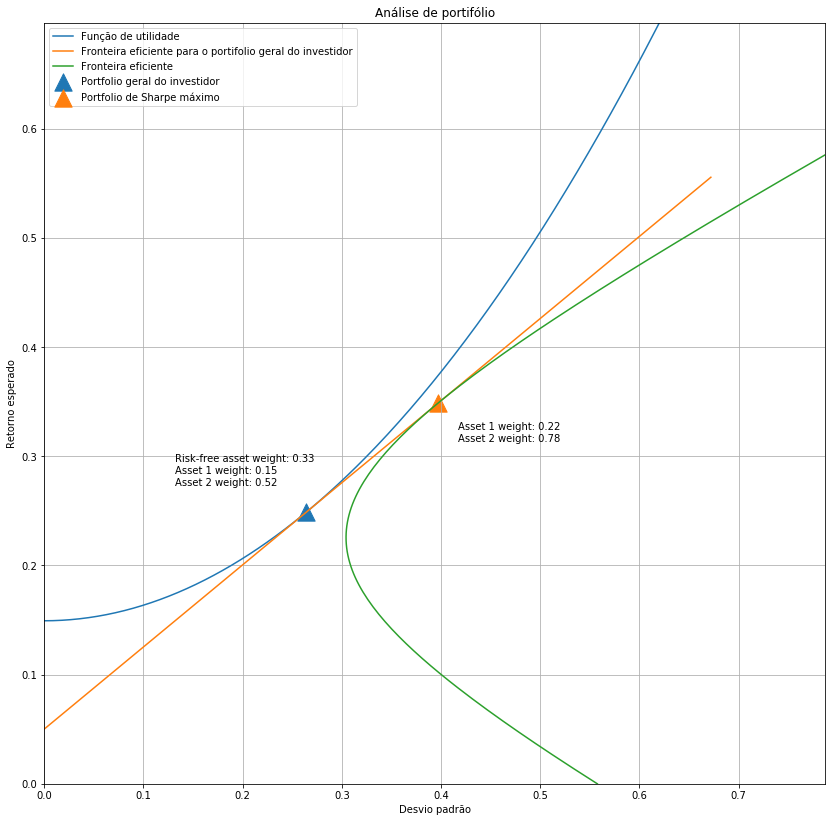

{'bench_ticker': 'BOVA11',
 'tickers': ['VALE3', 'SUZB3'],
 'returns':                VALE3     SUZB3    BOVA11
 Date                                    
 2019-01-02  0.000000  0.000000  0.000000
 2019-01-03  0.001138 -0.042746 -0.040908
 2019-01-04  0.005682  0.016779  0.065102
 2019-01-07 -0.000226 -0.045781 -0.005365
 2019-01-08  0.003956  0.009763  0.009632
 2019-01-09  0.016774  0.059945  0.024423
 2019-01-10  0.001107  0.012770 -0.010989
 2019-01-11 -0.000442  0.000000 -0.013559
 2019-01-14  0.009183  0.003603  0.004200
 2019-01-15 -0.006578  0.084615 -0.004753
 2019-01-16  0.005960  0.043972  0.005731
 2019-01-17  0.008996 -0.026947  0.030009
 2019-01-18  0.006959  0.032581  0.009773
 2019-01-21  0.000324  0.027721  0.009496
 2019-01-22 -0.013385 -0.024561 -0.003618
 2019-01-23  0.018600  0.030576  0.010349
 2019-01-24  0.011493  0.046030  0.008985
 2019-01-28 -0.022194  0.023566 -0.245592
 2019-01-29  0.001195 -0.021801  0.008971
 2019-01-30  0.014427 -0.029369  0.090313
 2019-

In [102]:
two_assets = TwoAssetsPortfolio(['VALE3', 'SUZB3'], [0.5, 0.5], 0.05, 2.85)

two_assets.plot_curves()

two_assets.__dict__

In [103]:
two_assets.print_assets_var()

two_assets.print_assets_mc_var()

1-day 95% V@R for VALE3 is 27382.65
1-day 95% V@R for SUZB3 is 39022.72
1-day 95% Monte Carlo V@R for VALE3 is 1739.63
1-day 95% Monte Carlo V@R for SUZB3 is 2512.75


In [104]:
class VanillaPortfolioData():
    
    def __init__(self, u, var, rho):
        self.u = u
        self.var = var
        self.std = [np.sqrt(v) for v in self.var]
        self.rho = rho

In [107]:
class VanillaPortfolio(VanillaPortfolioData, PortfolioOptmizer, RiskManager):
    
    def __init__(self, u, var, rho, r_f, gamma, portfolio_value=100*1000):
        super().__init__(u, var, rho)
        self.r_f = r_f
        self.gamma = gamma
        self.portfolio_value = portfolio_value
        self.load_params()
        self.tickers = ['asset_1', 'asset_2']
        self.assets_values = [portfolio_value*self.w1_pgi, portfolio_value*self.w2_pgi]
        self.weights = [self.w1_pgi, self.w2_pgi]
        self._gen_assets_var()
        self.portfolio_var = self.valueAtRisk(self.portfolio_value, self.std_pgi, u=self.u_pgi)        


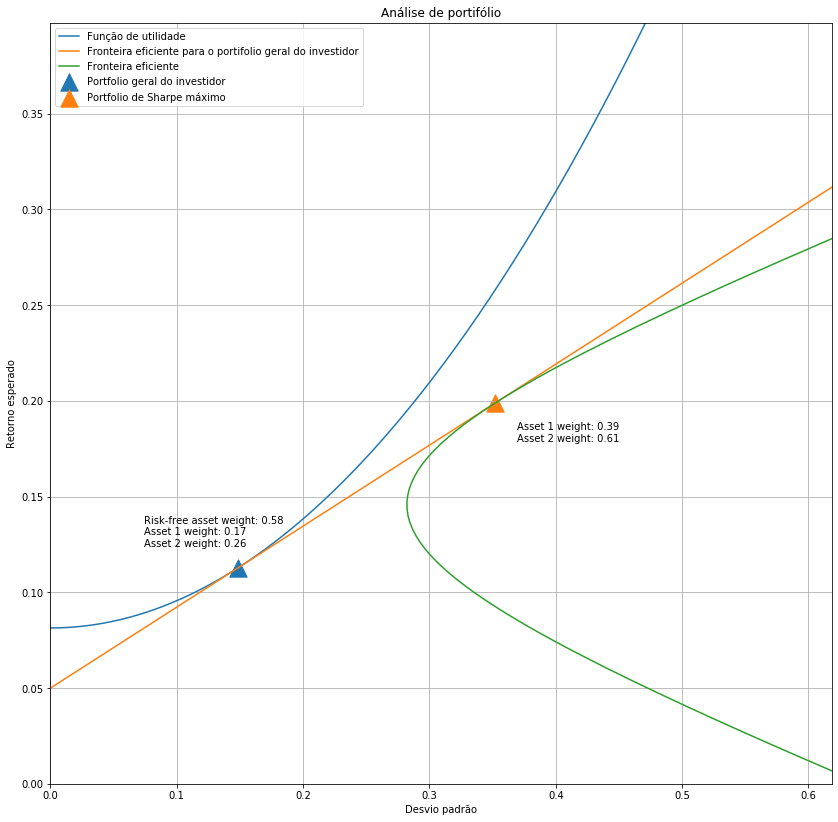

{'u': [0.12, 0.25],
 'var': [0.09, 0.25],
 'std': [0.3, 0.5],
 'rho': 0.25,
 'r_f': 0.05,
 'gamma': 2.85,
 'portfolio_value': 100000,
 'u_for_minimal_variance_risk_portfolio': 0.1457547169811321,
 'w_1_minimal_variance': 0.80188679245283,
 'w_2_minimal_variance': 0.19811320754717002,
 'minimal_variance_risk_portfolio': 0.07959905660377359,
 'u_for_maximum_sharpe': 0.19876847290640395,
 'w_1_max_sharpe': 0.3940886699507388,
 'w_2_max_sharpe': 0.6059113300492612,
 'variance_for_maximum_sharpe': 0.12366837341357474,
 'max_sharpe_ratio': 0.42304014344145036,
 'risk_asset_composition_pgi': 0.42209226770630265,
 'u_pgi': 0.11279402209226769,
 'var_pgi': 0.022032990207813224,
 'std_pgi': 0.1484351380496317,
 'w1_pgi': 0.166341780376868,
 'w2_pgi': 0.2557504873294347,
 'w_rf_pgi': 0.5779077322936974,
 'max_utility': 0.08139701104613384,
 'tickers': ['asset_1', 'asset_2'],
 'assets_values': [16634.1780376868, 25575.048732943465],
 'weights': [0.166341780376868, 0.2557504873294347],
 'assets_var

In [108]:
vanilla = VanillaPortfolio([0.12, 0.25], [0.09, 0.25], 0.25, 0.05, 2.85)

vanilla.plot_curves()

vanilla.__dict__